# 6. BS-Side: Channel Estimation and Equalization for SSB-PBCH in 5G Networks

The objective of the wireless communication system is to decode the transmitted data at the receiver. Before decoding the data, the receiver must estimate the channel between the transmitter and itself. However, wireless channels are dynamic and subject to various environmental factors such as multipath fading, shadowing, and interference. By accurately estimating the wireless channel, the receiver can decode the transmitted data without any error . Error-free decoding of data results in higher throughput and lower BLER, thus making accurate channel estimation in wireless communication crucial. In this experiment, we will discuss different techniques for channel estimation and use this estimated channel to decode the SSB.

## 6.1 Import Libraries
### 6.1 Import Python and SDR Libraries

In [1]:

%matplotlib widget

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
import sionna as sn
import adi
import matplotlib.pyplot as plt


### 6.1 Import 5G Toolkit Libraries 

In [2]:

import sys
sys.path.append("../../../../")

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualizationPBCH, DMRSParameterDetection, CarrierFrequencyOffsetEstimation
from toolkit5G.OFDM               import OFDMDemodulator
from toolkit5G.PhysicalChannels   import PBCHDecoder


## 6.1 Emulation Parameters

In [3]:

# System Parameters
center_frequency    = 1e9     # Carrier frequency for signal transmission

# OFDM Parameters
Bandwidth           = 10*10**6 # bandwidth
fftSize             = 1024    # FFT-size for OFDM
subcarrier_spacing  = 30000   # Subcarrier spacing
numOFDMSymbols      = 14      # Number of OFDM symbols considered for emulation | 1 slot
sample_rate         = fftSize*subcarrier_spacing # sample rate required by OFDM and DAC/ADC of SDR

# Pulse Shaping
numSamplesPerSymbol = 1

# number of samples returned per call to rx()
buffer_size         = int(4*fftSize*1.2*numSamplesPerSymbol*numOFDMSymbols)


## 6.1 PBCH Payload Generation: MIB + ATI

In [4]:

nSymbolFrame= 140*int(subcarrier_spacing/15000);   # Number of OFDM symbols per frame (Its a function of subcarrier spacing)

## This class fetches valid set of 5G parameters for the system configurations 
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing, fftsize = fftSize)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = tfParams.Neff          # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
fftsize     = tfParams.fftsize       # FFT-size for OFDM
lengthCP    = tfParams.lengthCP      # CP length

#### Generate MIB Information
lamda                           = 3e8/center_frequency;
nSCSOffset                      = 1
ssbParameters                   = GenerateValidSSBParameters(center_frequency, nSCSOffset, isPairedBand = False, 
                                                             intraFrequencyReselection = "allowed", 
                                                             withSharedSpectrumChannelAccess = False,
                                                             ssbSubCarrierOffset = 0)

systemFrameNumber               = ssbParameters.systemFrameNumber 
subCarrierSpacingCommon         = ssbParameters.subCarrierSpacingCommon 
ssbSubCarrierOffset             = ssbParameters.ssbSubCarrierOffset #ssbParameters.ssbSubCarrierOffset 
DMRSTypeAPosition               = ssbParameters.DMRSTypeAPosition 
controlResourceSet0             = ssbParameters.controlResourceSet0
searchSpace0                    = ssbParameters.searchSpace0

isPairedBand                    = ssbParameters.isPairedBand
nSCSOffset                      = ssbParameters.nSCSOffset 
choiceBit                       = ssbParameters.choiceBit 
ssbType                         = ssbParameters.ssbType 
nssbCandidatesInHrf             = 4     #ssbParameters.nssbCandidatesInHrf
ssbIndex                        = ssbParameters.ssbIndex
hrfBit                          = ssbParameters.hrfBit 
cellBarred                      = ssbParameters.cellBarred 
intraFrequencyReselection       = ssbParameters.intraFrequencyReselection 
withSharedSpectrumChannelAccess = ssbParameters.withSharedSpectrumChannelAccess

nFrames                         = 0.5
Nsc_ssb                         = 240  # Numbers of subcarriers in SSB
Nsymb_ssb                       = 4    # Numbers of OFDM symbols in SSB


## 6.1 PSS, SSS, PBCH, DMRS Generation

In [5]:

# Generate cell-ID 2 for PSS generation and cell-ID computation
N_ID2        = np.random.randint(3) 

# Generate PSS sequence
pssObject    = PSS(N_ID2);
pssSequence  = pssObject()

# Generate cell-ID 1 for SSS generation and cell-ID computation
N_ID1        = np.random.randint(336)
N_ID         = 3*N_ID1 + N_ID2

# Generate SSS sequence
sssObject    = SSS(N_ID1, N_ID2);
sssSequence  = sssObject()

# Generate DMRS sequence
dmrsLen      = 144;
dmrsObject   = DMRS("PBCH", N_ID, ssbIndex, nssbCandidatesInHrf, hrfBit)
dmrsSequence = dmrsObject(dmrsLen)

# Generate PBCH symbols
pbchObject   = PBCH(center_frequency, choiceBit, subCarrierSpacingCommon, DMRSTypeAPosition,
                   controlResourceSet0, searchSpace0, cellBarred, intraFrequencyReselection,
                   systemFrameNumber, ssbSubCarrierOffset, hrfBit, ssbIndex, N_ID,
                   nssbCandidatesInHrf)

pbchSymbols  = pbchObject()


## 6.1 Constellation Diagram: Base Station

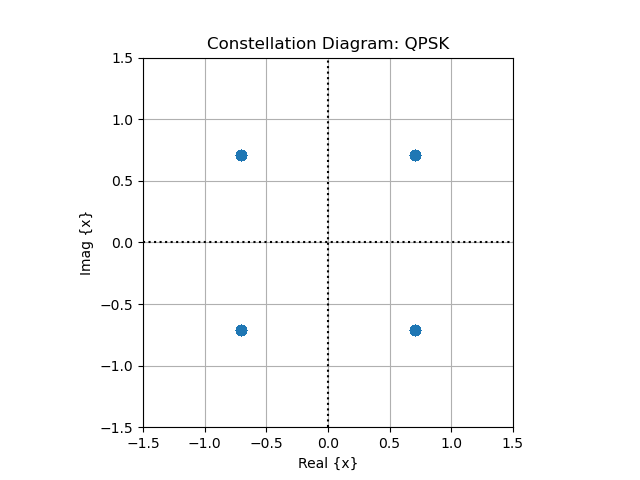

In [6]:

fig, ax = plt.subplots()
ax.set_aspect(True)
ax.scatter(np.real(pbchSymbols),  np.imag(pbchSymbols), s=48)
ax.grid()
ax.axhline(y=0, ls=":", c="k")
ax.axvline(x=0, ls=":", c="k")
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
plt.show()


## 6.1 SSB Generation

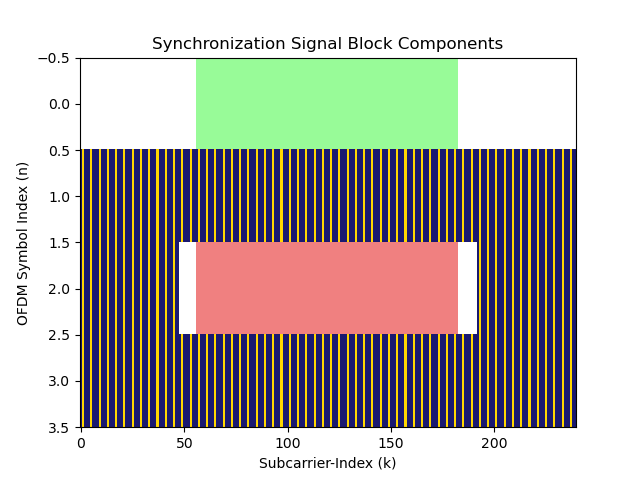

In [7]:

## Generate SSB Object
ssbObject    = SSB_Grid(N_ID, True)
ssb          = ssbObject(pssSequence, sssSequence, dmrsSequence, pbchSymbols)


# Loading SSB to Resource Grid
#####################################
# ssbPositionInBurst = np.ones(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst    = np.zeros(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst[0] = 1

ssbRGobject    = ResourceMapperSSB(ssbType=ssbType, carrierFrequency = center_frequency, 
                                   isPairedBand = isPairedBand, 
                                   withSharedSpectrumChannelAccess = withSharedSpectrumChannelAccess)

ssbGrid = ssbRGobject(ssb[0], ssbPositionInBurst, offsetInSubcarriers = 0,
                      offsetInRBs = 0, numRBs = nRB)[0:14]
fig, ax = ssbObject.displayGrid(option=1)


## 6.1 OFDM Implementation-- Transmission of SSB.

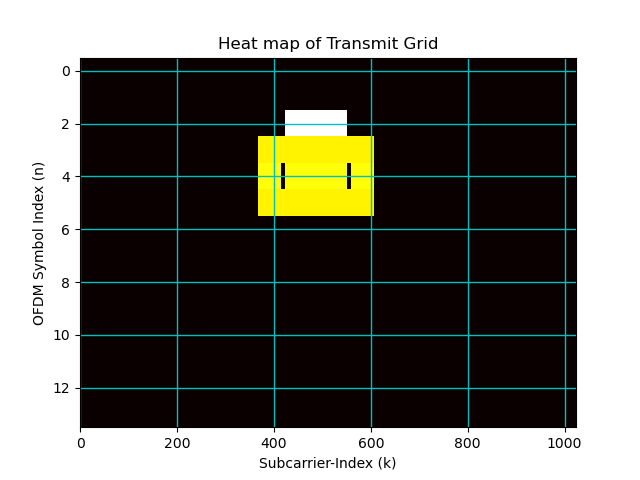

In [8]:

## Loading SSB to Resource Grid
numofGuardCarriers = (int((fftsize - Neff)/2), int((fftsize - Neff)/2))
offsetToPointA     = 0
firstSCIndex       = int(numofGuardCarriers[0] + offsetToPointA)


X = np.zeros((numOFDMSymbols, fftsize), dtype= np.complex64)  # Generating grid of size 14 X  FFT_Size.
X[:, firstSCIndex:firstSCIndex+ssbGrid.shape[-1]] = ssbGrid   # Loading SSB into grid.

### OFDM Modulation at Transmitter
modulator = OFDMModulator(lengthCP[1]) # OFDM modulation
x_time    = modulator(X).flatten()     # Time domain samples from OFDM modulation.


### Plot Resource Grid
fig, ax = plt.subplots()
plt.imshow(np.abs(X), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")
ax.set_title("Heat map of Transmit Grid")
plt.show()


## 6.1 SDR Setup

In [9]:

# SDR setup
sdr             = adi.Pluto("ip:192.168.2.1")       # Create object of SDR setup object and configure the IP of SDR connect to the system
sdr.sample_rate = int(sample_rate)                  # Sets the sample rate for the ADC/DAC of the SDR.

# Config Tx
sdr.tx_rf_bandwidth         = int(sample_rate)      # Set the bandwidth of the transmit filter | Can be set same as the sample rate
# For Pluto SDR, tx_rf_bandwidth should be between 200 kHz and 56 MHz.
sdr.tx_lo                   = int(center_frequency) # Sets the transmitter local oscillator frequency. The carrier is used to modulate/up-convert the analog information signal.
# For Pluto SDR, tx_lo can take a value between 325 MHz to 3.8 GHz.
sdr.tx_hardwaregain_chan0   = 0                     # Sets the gain (dB) of the transmitter power amplifier. The higher the value the more the power radiated by antenna. 
# For Pluto SDR, tx_hardwaregain_chan0 can take values between -90 to 0.


## 6.1 Transmission

In [10]:

# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers

sdr.tx(1.4*2**17*(x_time.repeat(1))) # start transmitting
